In [30]:
lambda  (y = x+7, y*x+2)

SyntaxError: invalid syntax (<ipython-input-30-2a957925a916>, line 1)

In [23]:
f(5)

27

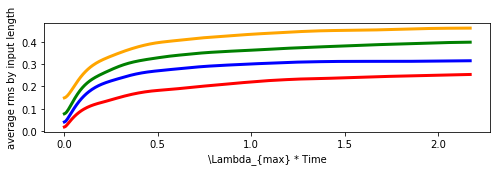

In [34]:
DMD_2bit = np.load('DMD_Nres_1000_2bit/DMD_Nres_1000_2bit.npy')
DMD_4bit = np.load('DMD_Nres_1000_4bit/DMD_Nres_1000_4bit.npy')
DMD_6bit = np.load('DMD_Nres_1000_6bit/DMD_Nres_1000_6bit.npy')
DMD_8bit = np.load('DMD_Nres_1000_8bit/DMD_Nres_1000_8bit.npy')

plt.figure(1,figsize=(8,2))
plt.ylabel('average rms by input length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(tt[:DMD_2bit.shape[0]]*lyap_exp_max, DMD_2bit, color='orange', linewidth=3.0)
plt.plot(tt[:DMD_4bit.shape[0]]*lyap_exp_max, DMD_4bit, color='green', linewidth=3.0)
plt.plot(tt[:DMD_6bit.shape[0]]*lyap_exp_max, DMD_6bit, color='blue', linewidth=3.0)
plt.plot(tt[:DMD_8bit.shape[0]]*lyap_exp_max, DMD_8bit, color='red', linewidth=3.0)
plt.savefig('DMD_encoding_depth_dependence.png')
plt.show;

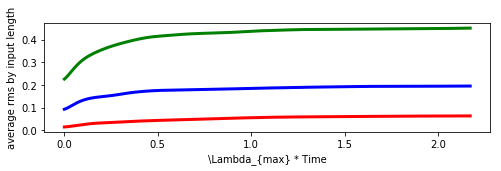

In [33]:
SLM_Nres_10000 = np.load('SLM_Nres_10000/SLM_8bit.npy')
SLM_Nres_1000 = np.load('SLM_Nres_1000/SLM_8bit.npy')
SLM_Nres_100 = np.load('SLM_Nres_100/SLM_8bit.npy')

plt.figure(1,figsize=(8,2))
plt.ylabel('average rms by input length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(tt[:SLM_Nres_10000.shape[0]]*lyap_exp_max, SLM_Nres_10000, color='red', linewidth=3.0)
plt.plot(tt[:SLM_Nres_1000.shape[0]]*lyap_exp_max, SLM_Nres_1000, color='blue', linewidth=3.0)
plt.plot(tt[:SLM_Nres_100.shape[0]]*lyap_exp_max, SLM_Nres_100, color='green', linewidth=3.0)
plt.savefig('SLM_Nres_dependence.png')
plt.show;

In [1]:
#!/usr/bin/python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# import os
# import sys
import numpy as np

import time

from reservoir import Reservoir
import data

%load_ext autoreload
%autoreload 1
%aimport data
%aimport reservoir

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
roll_num = 500
spatial_points = 50
enc_depth = 10
n_res = 5000
b = Reservoir(n_res=n_res, input_scale=2, train_method='ridge', train_param=2000,
              weights_type='complex gaussian', random_projection='simulation',
              activation_fun='phase', activation_param=1,encoding_method='phase', 
              encoding_param=1, input_dim=spatial_points+1, forget=100) 
#(2**enc_depth)*spatial_points spatial_points+1

In [3]:
ks_data, xx, tt = data.kuramoto_sivashinsky(sequence_length=2000, n_sequence=10, spatial_points=spatial_points)
y = data.roll_and_concat(ks_data, roll_num=roll_num)
b.fit(ks_data, y)

Start of training...
Initialization finished. Elapsed time:
2.0180552005767822
100%|██████████| 2001/2001 [00:33<00:00, 58.91it/s]
Iterations finished. Elapsed time:
338.77355790138245
Training finished. Elapsed time:
459.7713279724121
Training score:
0.8975996301415721


Reservoir(activation_fun='phase', activation_param=1, encoding_method='phase',
          encoding_param=1, forget=100, input_dim=51, input_scale=2, n_res=5000,
          opu_transform=None, random_projection='simulation',
          random_state=<mtrand.RandomState object at 0x7f973f18c510>,
          res_scale=1, save=0, train_method='ridge', train_param=2000,
          verbose=1, weights_type='complex gaussian')

In [4]:
ks_data, xx, tt = data.kuramoto_sivashinsky(sequence_length=2000, n_sequence=1, spatial_points=spatial_points)
y = data.roll_and_concat(ks_data, roll_num=roll_num)[:, b.forget:, :]
y_target = y.reshape(-1, y.shape[-1])
pred_output, valid_score = b.score(ks_data, y_target)

Start of testing...
Initialization finished. Elapsed time:
0.009170055389404297
100%|██████████| 2001/2001 [00:31<00:00, 63.83it/s]
Iterations finished. Elapsed time:
31.368201971054077
Testing finished. Elapsed time:
48.718528509140015
Testing finished. Elapsed time:
459.7713279724121
Testing score:
-0.25469957670586374


/home/mushegh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


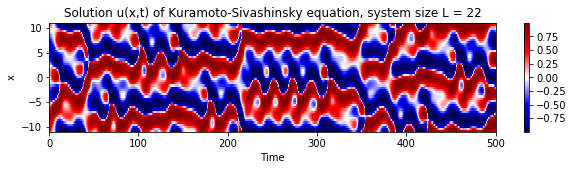

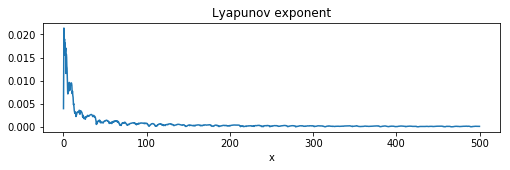

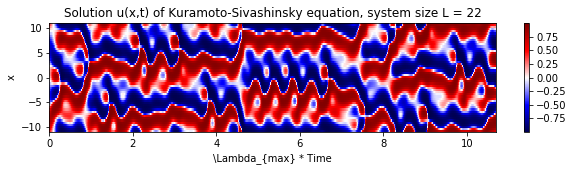

In [5]:
# ks_data, xx, tt = data.kuramoto_sivashinsky(sequence_length=2000, n_sequence=1, spatial_points=50)
tt = np.linspace(np.amin(tt), np.amax(tt), tt.shape[2])
xx = xx.flatten()
d = ks_data[0, :,:]

plt.figure(1,figsize=(10,2))
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh(tt, xx, d.T, cmap='seismic')
plt.colorbar(im)

d_rolled = d - np.roll(d, -1, axis=1)
d_rolled = d_rolled[:, :-1]
lyap_exp = (np.sum(np.log(np.abs(d_rolled/d_rolled[0, :])).T/tt, axis=0)/np.amax(tt))[1:]
lyap_exp_max = np.amax(lyap_exp)
plt.figure(2,figsize=(8.2,2))
plt.title('Lyapunov exponent')
plt.xlabel('x')
im=plt.plot(tt[:-1], lyap_exp)

plt.figure(3,figsize=(10,2))
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')
im=plt.pcolormesh(tt*lyap_exp_max, xx, d.T, cmap='seismic')
plt.colorbar(im)

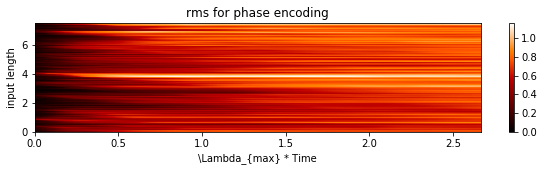

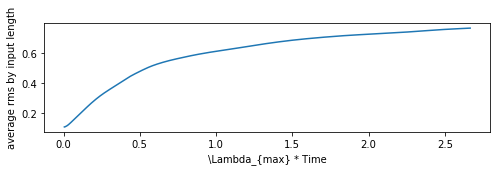

In [6]:
# rms for phase encoding

length_input = pred_output.shape[0]-roll_num
rms = np.zeros((length_input, roll_num))
for n_input in range(1, length_input):
    for n_pred in range(1, roll_num):
        d1 = pred_output[n_input, :].reshape(-1, spatial_points+1)[0:n_pred,:]
        d2 = y_target[n_input:n_input+n_pred, 0:spatial_points+1]
        
        rms[n_input, n_pred] = np.sqrt(1./(n_pred*(spatial_points+1))*np.sum((d1.flatten() - d2.flatten())**2))

time_input = tt[0:n_input+1]*lyap_exp_max
time_pred = tt[0:roll_num]*lyap_exp_max

plt.figure(1,figsize=(10,2))
plt.title('rms for phase encoding')
plt.ylabel('input length')
plt.xlabel('\Lambda_{max} * Time')
im=plt.pcolormesh(time_pred, time_input, rms[:,:], cmap='gist_heat')
plt.colorbar(im)
plt.show;

plt.figure(2,figsize=(8,2))
plt.ylabel('average rms by input length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(time_pred[1:], np.sum(rms[:,1:], axis=0)/length_input)
plt.show;
np.save('SLM_timesteps_20000.npy', np.sum(rms[:,1:], axis=0)/length_input)

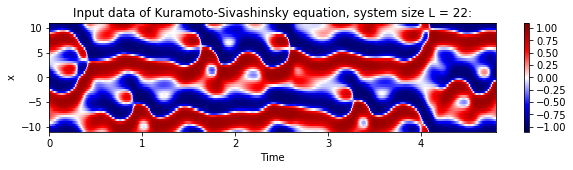

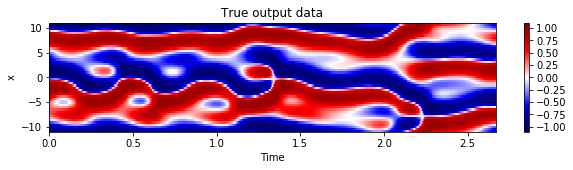

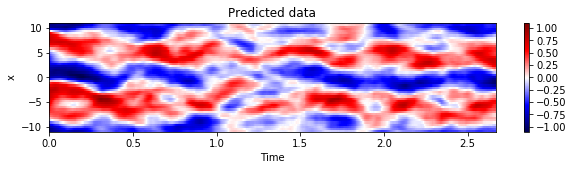

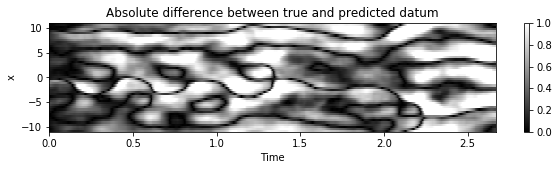

In [12]:
n_input = 900 #round(pred_output.shape[0]/2-300)

input_data = y_target[0:n_input, 0:spatial_points+1]

prediction = np.zeros((roll_num, spatial_points + 1))
for i in range(roll_num):
    prediction[i, :] = pred_output[n_input, i*(spatial_points+1):(i+1)*(spatial_points + 1)]
    
targetted_data = y_target[n_input:n_input+roll_num, 0:spatial_points+1]

time = tt[0:n_input+roll_num]*lyap_exp_max
vmax = max(abs(np.concatenate((prediction,targetted_data,input_data)).flatten()))
vmin = -vmax

fig1 = plt.figure(1, figsize=(10,2))
plt.title('Input data of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh(time[0:n_input], xx, input_data.T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar(im)
plt.savefig('SLM_input_data.png')

fig2 = plt.figure(2, figsize=(10,2))
plt.title('True output data')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh(time[0:roll_num], xx, targetted_data.T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar(im)
plt.savefig('SLM_true_data.png')

fig3 = plt.figure(3, figsize=(10,2))
plt.title('Predicted data')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh(time[0:roll_num], xx, prediction.T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar(im)
plt.savefig('SLM_predicted_data.png')

fig4 = plt.figure(4, figsize=(10,2))
plt.title('Absolute difference between true and predicted datum')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh(time[0:roll_num], xx, np.abs((targetted_data-prediction).T), cmap='gray', vmin=0, vmax=1)
plt.colorbar(im)
plt.savefig('SLM_true_predicted_difference.png')

<function matplotlib.pyplot.show(*args, **kw)>

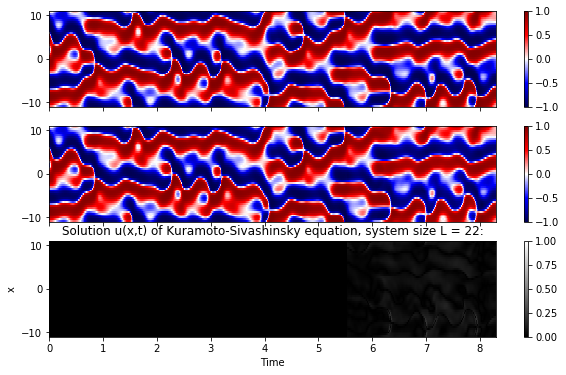

In [9]:
n_input = 1000 #round(pred_output.shape[0]/2-300)
prediction = np.zeros((roll_num, spatial_points + 1))
for i in range(roll_num):
    prediction[i, :] = pred_output[n_input, i*(spatial_points+1):(i+1)*(spatial_points + 1)]
all_data = np.concatenate((y_target[0:n_input, 0:spatial_points+1], prediction*(1/np.amax(prediction))))

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10,6))
data_1 = y_target[0:n_input+roll_num, 0:spatial_points+1].T
data_2 = all_data.T
data_3 = y_target[0:n_input+roll_num, 0:spatial_points+1].T-all_data.T
time = tt[0:n_input+roll_num]*lyap_exp_max
vmax = max(abs(np.concatenate((data_1,data_2,data_3)).flatten()))
vmin = -vmax
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=axs[0].pcolormesh(time, xx, y_target[0:n_input+roll_num, 0:spatial_points+1].T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[0])

im=axs[1].pcolormesh(time, xx, all_data.T, cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[1])

im=axs[2].pcolormesh(time, xx, np.abs(y_target[0:n_input+roll_num, 0:spatial_points+1].T-all_data.T), cmap='gray', vmin=0, vmax=1)
plt.colorbar(im, ax=axs[2])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

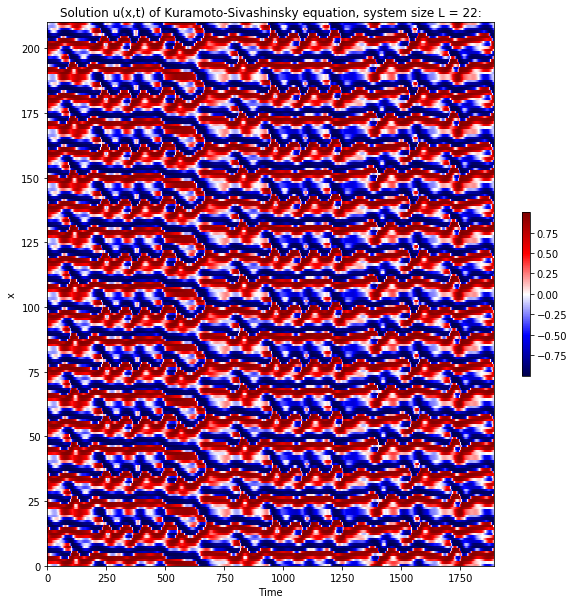

In [8]:
plt.figure(figsize=(10,10))
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh(y_target.T[:,:-roll_num], cmap='seismic') # tt[:, b.forget:], xx
plt.colorbar(im, shrink=0.3)
# plt.axes().set_aspect(.5) # 4*spatial_points/sequence_length
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

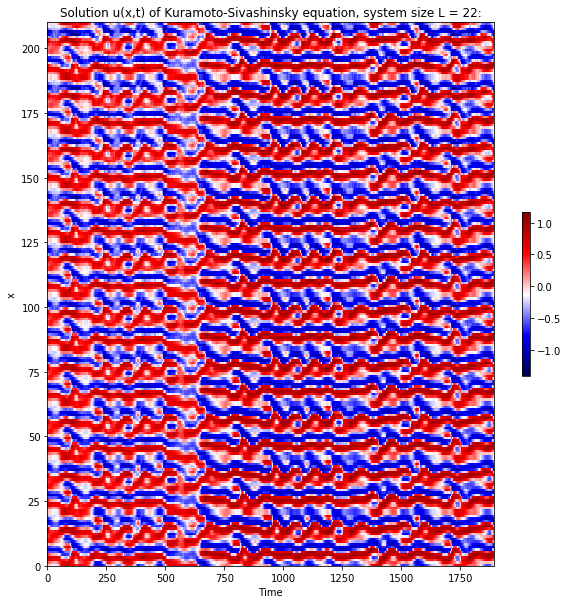

In [6]:
plt.figure(figsize=(10,10))
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh(pred_output.T[:,:-roll_num], cmap='seismic')
plt.colorbar(im, shrink=0.3)
# plt.axes().set_aspect(.5) # 4*spatial_points/sequence_length
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

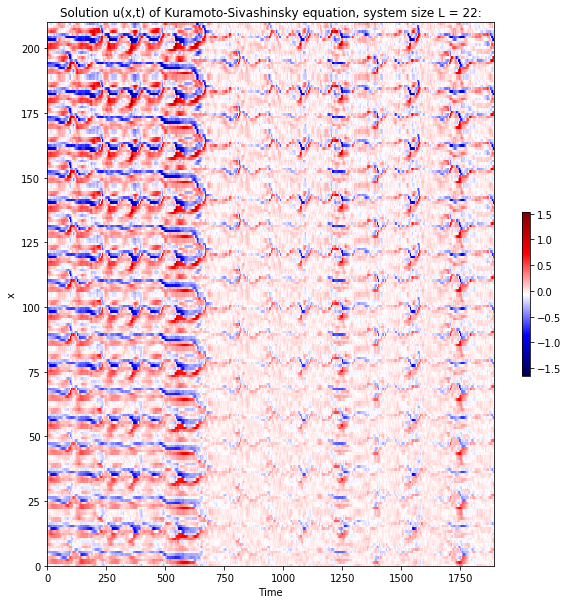

In [7]:
plt.figure(figsize=(10,10))
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=plt.pcolormesh((y_target.T - pred_output.T)[:,:-roll_num], cmap='seismic')
plt.colorbar(im, shrink=0.3)
# plt.axes().set_aspect(.5) # 4*spatial_points/sequence_length
plt.show